**General tips for computing and plotting discrete fourier transforms (DFT)**

- Let g(t) be some time signal that’s sampled at $dt$ to get a discrete array/list `g = [ … ]`
- You don’t need to code your own DFT, use numpy:  `A = numpy.fft.fft(g) * dt`
- You should also use `numpy.fft.fftshift( A )` to shift the fft output such that the 0-frequency component is centered (see why here https://docs.scipy.org/doc/numpy/reference/routines.fft.html#background-information) which you probably want when plotting
- You can use `f_axis = numpy.fft.fftshift( numpy.fft.fftfreq(len(g), dt) )` to create the frequency axis for plotting the shifted spectrum
- Keep in mind the fft output is in general complex, so to compare two fourier transforms (e.g. DFT vs CFT) you should compare either the real and imaginary parts ($z = x + i y$), or the phase and amplitude ($z = r e^{i\theta}$ ). Amplitude plots are most useful for this lab, show all 4 aspects though if you want.
- Note numpy fft assumes the time signal starts at $t = 0$, if yours doesn’t you should center it at zero. If you don’t then the complex components (x and y, or phase) will be off, but the amplitude should not change (why? analytically, recall that axis shifts in either domain are equivalent to complex exponential scaling, which has amplitude 1, in the other domain).
- If your time signal g is centered at zero, a hack to ‘rotate it’ to start at zero (and then take the fft and fftshift that) is to do: `fftshift( fft( ifftshift(g) ) )` (you may see mention of this online)

# Fourier transform of Gaussian Functions (6 pts)

A common function used for the convolution of time series data is the Gaussian function

$$  g(t) = \frac{1}{\sqrt{\pi} t_H} e^{-(t/t_H)^2}, $$

where $t_H$ is the half duration.

 1. Plot $g(t)$ for $t_H = 20$ and $t_H = 40$ sec on the same graph with domain $[-100, 100]$ and $dt=10^{-3}$.
 2. The analytical formula for the Fourier transform of $g(t)$ is

    $$ G(\omega) = e^\frac{-\omega^2 t_H^2}{4}. $$

    Compute the discrete Fourier transform (DFT) for both sampled $g(t)$
    time series, and compare them to the analytical $G(\omega)$
    for both $t_H$'s on the same graph.

    __Hints__: 
    - As numpy fft assumes signal starts from time 0, you can
    use the shift property of Fourier transform to first shift the $g(t)$
    to start from zero, and after `fftshift(fft())` operations, multiply
    the spectrum by complex exponential sinusoid function.
    - You need to sample the theoretical curve $G(w)$ with `w_axis = 2*pi*f_axis`, or else rewrite it as $G(f=\frac{w}{2\pi})$ if you'd rather sample it with `f_axis`
    - As a guide (so you can be confident of your fft utilization for the remainder of the lab), we expect that the amplitudes (use `numpy.abs(…)`) of the discrete FT and the continuous FT essentially match. The phase won’t necessarily match.
 3. Comment on the effect of filtering a general input time function $f(t)$ by $g(t)$
    (i.e. convolution of $f(t)$ with $g(t)$), and explain the difference in filtered output
    after applying Gaussian functions with $t_H = 20$ or $40$ secs.
 4. Comment on how this is related to the time-frequency uncertainty principle (a signal cannot
    be infinitesimally sharp both in time and frequency).

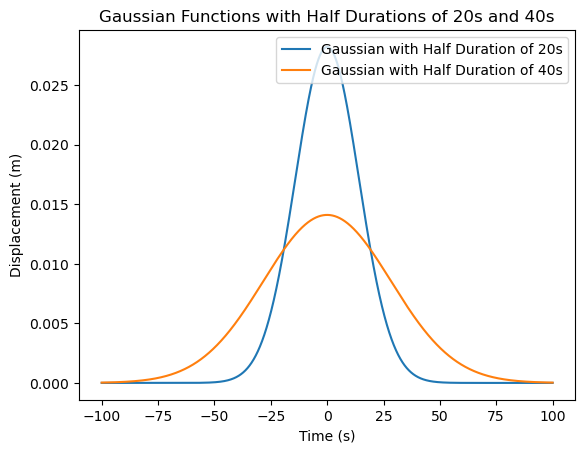

(-0.5, 0.5)

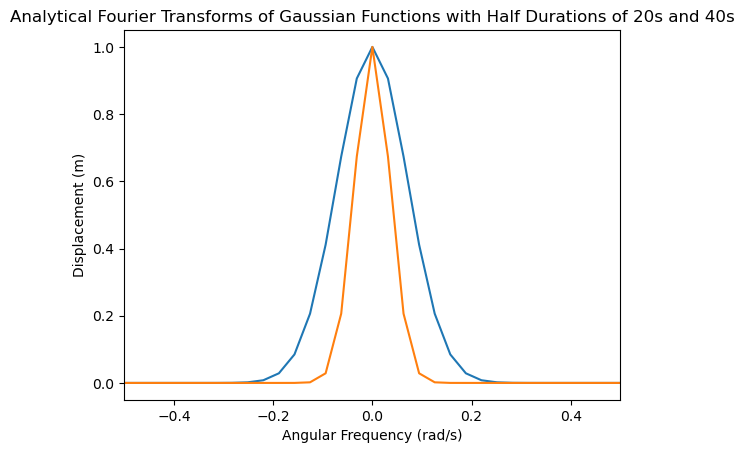

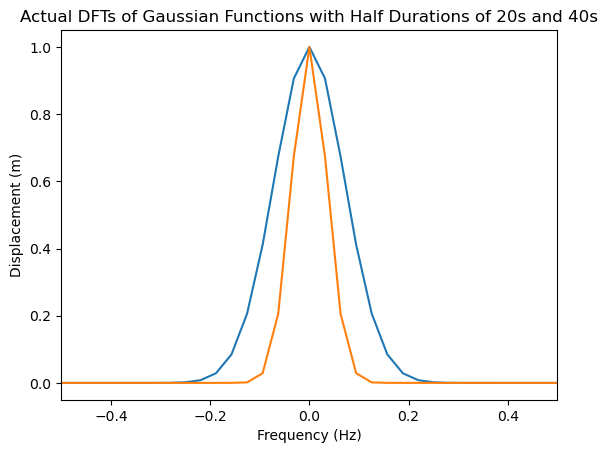

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## QUESTION 1 

dt = 0.001

# Helper function to make the Gaussian Functions
def gaussian(t, t_H):
    return (1 / (np.sqrt(np.pi) * t_H)) * np.exp(-(t / t_H)**2)


# Sampling range for Gaussians
sample_range = np.arange(-100, 100, dt)


# Plot 1: Gaussian functions with Half Durations of 10s and 20s 
plt.plot(sample_range, gaussian(sample_range, 20), label = "Gaussian with Half Duration of 20s")
plt.plot(sample_range, gaussian(sample_range, 40), label = "Gaussian with Half Duration of 40s")
plt.title("Gaussian Functions with Half Durations of 20s and 40s")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (m)")
plt.legend()
plt.show()


## QUESTION 2

g_20 = gaussian(sample_range, 20)
g_40 = gaussian(sample_range, 40)

# Number of samples
N = len(g_20)

# Frequency axis for plotting
f_axis = np.fft.fftshift(np.fft.fftfreq(N, dt))

# Angular frequency axis for plotting
w_axis = 2 * np.pi * f_axis

# Analytical FT := G(w)
analytical_20 = np.exp(-((w_axis)**2)*(20**2)*0.25)
analytical_40 = np.exp(-((w_axis)**2)*(40**2)*0.25)

# Compute the FFT of the signals (applying the shift property)
dft_20 = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(g_20))) * dt
dft_40 = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(g_40))) * dt

plt.figure();
plt.title("Analytical Fourier Transforms of Gaussian Functions with Half Durations of 20s and 40s")
plt.xlabel("Angular Frequency (rad/s)")
plt.ylabel("Displacement (m)")
plt.xlim((-0.5, 0.5))
plt.plot(w_axis, analytical_20)
plt.plot(w_axis, analytical_40)


plt.figure();
plt.title("Actual DFTs of Gaussian Functions with Half Durations of 20s and 40s")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Displacement (m)")
plt.plot(w_axis, np.abs(dft_20))
plt.plot(w_axis, np.abs(dft_40))
plt.xlim((-0.5, 0.5))

# Fourier transform of Window Functions (6 pts)

A continuous time signal $f(t)$ can be truncated into a signal of finite length
$T$ by window functions $b(t)$:

$$ g(t) = f(t) b(t) $$

Typical window functions include:

 * Boxcar function
    $$b(t) =
    \begin{cases}
    1 & 0 \leq t \leq T
    \\
    0 & \text{else}
    \end{cases}
    $$
 * Hann window
    $$b(t) =
    \begin{cases}
    \frac{1}{2} \left( 1 - \cos \frac{2 \pi t}{T} \right) & 0 \leq t \leq T
    \\
    0 & \text{else}
    \end{cases}
    $$

Now let $T = 10$ sec, and sample both window functions by $\Delta t = 0.01$ sec:

 1. Plot both window functions on the same graph.
 2. Calculate the Fourier transform of both functions by numpy `fft()`. Pay extra attention to
    how you interpret the corresponding frequencies of output results from python.
    (_Hint_: `fftshift()` may be useful. Also pay attention to the length of the input signal
    (> 10 sec), as it dictates the frequency resolution for the spectrum.)
 3. Plot the Fourier transform of both functions in the appropriate frequency range on the
    same graph.
 4. Based on the FTs, comment on the effect of truncating a continuous time series by either
    window on its frequency spectrum $G(\omega)$ compared to the original spectrum $F(\omega)$.
 5. Speculate on the advantages and disadvantages of boxcar and Hann window functions for truncation.

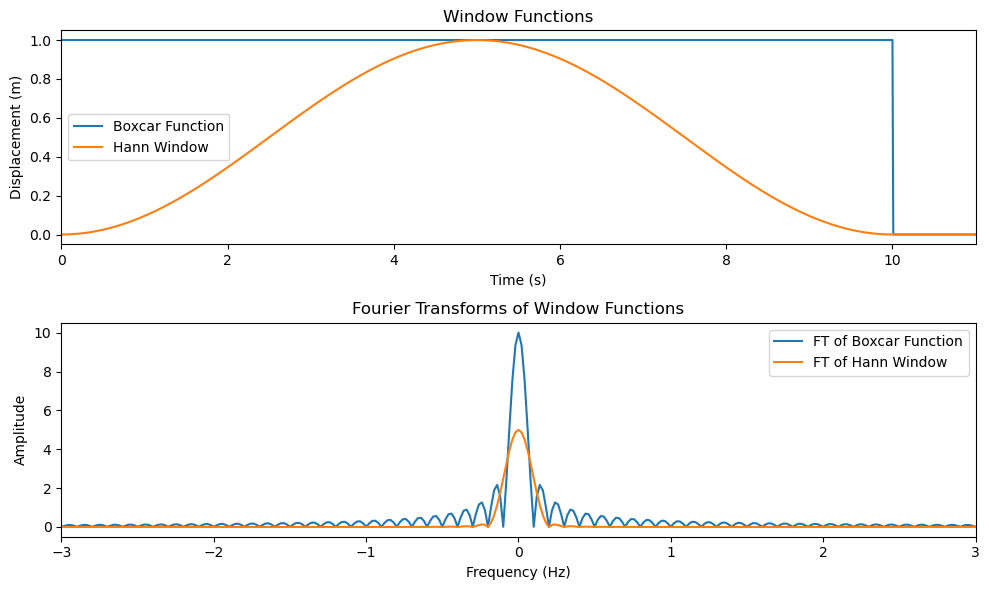

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Define your variables
T = 10  # Period in seconds
dt = 0.01  # Sampling Range

# Define the time array from 0 to 5T
t = np.arange(0, 5*T, dt)  

# Boxcar Function
def boxcar(t):
    y = np.zeros_like(t)
    
    # For 0 <= t <= T
    y[(t <= T)] = 1
    return y
    
# Hann Window
def hann(t):
    y = np.zeros_like(t)
    
    # For 0 <= t <= T
    y[(t <= T)] = (1/2) * (1 - np.cos((2*np.pi*t[(t <= T)])/T))
    return y

# Generate the signals
boxcar_signal = boxcar(t)
hann_window = hann(t)

# Shift the signals
boxcar_signal_shifted = np.fft.ifftshift(boxcar_signal)
hann_window_shifted = np.fft.ifftshift(hann_window)

# Perform Fourier transforms on shifted signals
dft_boxcar = np.fft.fft(boxcar_signal_shifted) * dt
dft_hann = np.fft.fft(hann_window_shifted)* dt

# Shift the Fourier transforms
shifted_dft_boxcar = np.fft.fftshift(dft_boxcar)
shifted_dft_hann = np.fft.fftshift(dft_hann) 

# Frequency axis for plotting
f_axis = np.fft.fftshift(np.fft.fftfreq(len(t), dt))

# Plot the signals and Fourier transforms on the same graph
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(t, boxcar_signal, label="Boxcar Function")
plt.plot(t, hann_window, label="Hann Window")
plt.title("Window Functions")
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.xlim(0,11)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(f_axis, np.abs(shifted_dft_boxcar), label="FT of Boxcar Function")
plt.plot(f_axis, np.abs(shifted_dft_hann), label="FT of Hann Window")
plt.title("Fourier Transforms of Window Functions")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(-3, 3)
plt.legend()
plt.tight_layout()
plt.show()

4) Based on the FTs, comment on the effect of truncating a continuous time series by either window on its frequency spectrum 𝐺(𝜔) compared to the original spectrum 𝐹(𝜔)

If one were to truncate a continuous signal x(t) with a boxcar function, spectral leakage would occur due to the discontinuities at either end of the boxcar, represented by the series of smaller peaks at either side of the central peak. This leakage introduces inaccuracies in frequency analysis by adding frequencies that may not have been present in the original signal.

On the other hand, truncating x(t) with a Hann window doesn't introduce as much spectral leakage, indicated by the lack of peaks at either side of the central one. However, the central peak is noticeably wider than the boxcar's. While the wider peak indicates a smoother spectrum with reduced spectral leakage, it may compromise precision in distinguishing closely spaced frequency components.

5) Speculate on the advantages and disadvantages of boxcar and Hann window functions for truncation.

The boxcar function, due to its sharper central peak, seems to provide higher resolution of frequency components compared to the Hann window, which has a wider and flatter central peak. Furthermore, the boxcar function is very straightforward to implement. 

However, the boxcar function has significantly more spectral leakage commpared to the Hann window, which could distort the frequency analysis. In contrast, the wider main peak of the Hann window balances precision and smoothness in the frequency domain. While it may sacrifice some precision compared to the boxcar window, it provides a smoother spectrum with reduced spectral leakage.


# Radial Distribution Function (12 pts)

**Background**

Liquids have no fixed internal structure. Yet they do have some short range order in the sense
that they have preferred intermolecular spacings, which are determined by the locations of minima
in the intermolecular potentials. The microscopic structure of liquids is often characterized by a
quantity known as the Radial Distribution Function $g(r)$, which is essentially the probability (Relative
to the average probability, which means that $g(r)$ tends to 1 at large $r$, where the neighbour is too far
away to feel any interaction.) that a molecule has a neighbouring molecule at distance $r$. Typically $g(r)$
shows a value that approaches zero at small $r$ since molecules cannot occupy the same space; it also shows a
peak at the preferred distance of nearest neighbours, and secondary peaks at preferred distances of more distant
neighbours. If a suitable collimated beam of particles (e.g. X-rays or neutrons) is sent through a
sample of the liquid, some of the particles are scattered. The number of particles scattered through
a given angle is related to the Fourier Transform of $g(r)$ evaluated at the wavenumber $k$
corresponding to the transverse momentum transfer associated with that scattering angle. Kittel derives
this relationship in Chapter 17 of Introduction to Solid State Physics.

If this all sounds complicated, all you need to know here is that something called the Structure
Factor $S(k)$ is effectively measured by looking at the scattered intensity as a function of
scattering transverse wavenumber $k$ (proportional to scattering angle), and that the Radial Distribution
Function is related to it by

$$ g(r) = 1 + \frac{1}{2 \pi^2 \rho r} \int_0^\infty k \left( S(k) - 1 \right) \sin(kr) dk $$

where $\rho$ is liquid number density (number of atoms per unit volume, computable from the three
constants mentioned in the introduction), $k$ is wavenumber, and $r$ is radius.

 1. You may have noticed some resemblance between expression (6) and the Fourier transform.
    First show that the integration part $\int_0^\infty k (S(k) - 1) \sin(kr) dk$
    can be rewritten as

    $$p(r) = \int_{-\infty}^\infty \frac{1}{2i} k \left( S(k) - 1 \right) e^{ikr} dk.$$
    
    __Hint__: The structure factor S(k) is even, since there should be no reason why scattering intensity would be different for one direction (+k) compared to its opposite (−k). Using the fact that S(k) is even may be useful.  

 2. Now we can make some connections between the Radial Transfer Function and the Fourier
    Transform, if we substitute $r \rightarrow t$ and $k \rightarrow \omega$. What is the Fourier transform
    $P(k)$ of $p(r)$? Is $P(k)$ a real, imaginary or general complex function? Is it even or odd? How will these
    affect $p(r)$? Is that what you expect? Plot $P(k)$ as a function of $k$ ranging from $-10 \mathrm{\mathring{A}}^{-1}$ to $10\mathrm{\mathring{A}}^{-1}$
    based on `argon.py` (i.e. import and use the variables defined there).
    
    __Hint__: In constructing $S(k)$ from `argon.py`, you should make an "even" array twice the length (minus 1) of YanData. 
    YanData represents the structure factor (i.e. $S(k)$) for argon sampled at the $dk$ defined in the `argon.py` file. 
	It's specifically $S(k)$ sampled from `k = 0` to `k = len(YanData) * dk`, so create an even function out to the same length in the negative direction (i.e. the "k-axis" it's sampled on would be `-(len(YanData)-1)*dk,  ... 0, ..., + (len(YanData)-1)*dk`).

 3. Write a Python function `[gn, rn] = RDFcalc(S, dk, rho)` to calculate Radial Distribution
    Function $g(r)$ from Structure Factor $S(k)$ data, sampled at $dk$, and density $\rho$, and output
    the RDF vector $g_n$ and its corresponding radial distance vector $r_n$.

    __Hint__: for Python `fft()` and `ifft()` functions, realize that the values of the Fourier Transform
    corresponding to negative frequencies are stored in the second half of the arrays given to
    (`ifft`) or obtained from it (`fft`). You also have to study the difference between the DFT and
    FT to multiply the right factors.
    
 4. With the data provided in `argon.py`, compute the corresponding Radial Distribution Function
    $g(r)$. Plot your results for $r$ from $0$ to $20\mathrm{\mathring{A}}$;. Over what range of radius can you trust your
    result?

    __Hint__: To check if your results make sense, recall that $g(r)$ is related to the probability that a
    molecule has a neighbouring molecule at distance $r$, therefore, should be close to $0$
    when $r \rightarrow 0$, i.e. two molecules can not occupy the same space, and you can
    set $g(r = 0) = 0$. Recall $\lim_{r->\infty}g(r)=1$. Also note the unit $\rho$ used in $g(r)$ formula (6).

 5. From the $g(r)$ you computed, estimate the average molecular radius $R_a$ of liquid argon. Give
    your reasoning and state what accuracy you can justify for your estimation.
    
 6. Now we explore the effect of sampling range. Yan sampled in wavenumber $k$ out to
    $k_{max} = 15.24\mathrm{\mathring{A}}^{-1}$, and he could have saved himself work by not collecting as much data,
    i.e., reducing $k_{max}$. But how much could he have reduced the sampling length $k_{max}$, while still
    seeing distinct peaks in the Radial Distribution Function? Also explain theoretically what you observe.

    __Hint__: Plot on top of the $g(r)$ obtained in Part 4, the $g(r)$'s you compute for a series of
    $k_{max}$ values. You can try half $k_{max}$ each time to look for changes. For the theoretical explanations
    for part 6 and 7, realize the interchangability of $t \leftrightarrow \omega$ ($r \leftrightarrow k$).

 7. To explore the effect of data sampling, let's assume Yan decided to save his work by sampling
    less often (i.e. increasing $dk$). How large a $dk$ can he use to be able to still recover the first
    two peaks clearly? State your answers and a theoretical justification for what you expect to
    see if you increase $dk$ too much.

    __Hint__: Plot on top of the $g(r)$ obtained from `argon.py` data, the $g(r)$'s you obtain when
    you subsample the same dataset. Try doubling $dk$ each time to observe the effect of coarser
    sampling.

We know the integrand is even, since both $k$ and $sin(kr)$ are odd and $S(k)$ is even (i.e., symmetric with respect to $k$). Thus, we can write:<br>  
$$ = \frac{1}{2} \left( \int_{-\infty}^{\infty} (k) (S(k)-1) sin(ikr) \, dk \right) $$

By expanding using Euler's formula:

$$ = \frac{1}{2} \int_{-\infty}^{\infty} \frac{1}{2i} (k) (S(k)-1) [e^{ikr}  - e^{-ikr}] \, dk $$

Next, separating the terms, we have:<br>  
$$ = \frac{1}{2} \left( \int_{-\infty}^{\infty} \frac{1}{2i} (k) (S(k)-1) e^{ikr} \, dk - \int_{-\infty}^{\infty} \frac{1}{2i} (k) (S(k)-1) e^{-ikr} \, dk \right) $$<br>  

We know $e^{ikr} = \cos(kr) + i\sin(kr)$ and $ e^{-ikr} = \cos(kr) - i\sin(kr)$. Since $\cos$ is an even function, its contribution to both $\int_{-\infty}^{\infty} e^{ikr} \, dk$ and $-\int_{-\infty}^{\infty} e^{-ikr} \, dk$ is 0. Thus, the $\sin$ terms are the only ones left (we have $i\sin(kr) - (-i\sin(kr)) = 2i\sin(kr)$). Therefore, we can express:<br>  
$$ \int_{-\infty}^{\infty} e^{ikr} \, dk = -\int_{-\infty}^{\infty} e^{-ikr} \, dk $$ <br>  

So going back to the original problem: <br>  
$$ \int_{0}^{\infty} k(S(k)-1)sin(kr) \, dk = 2 \left( \frac{1}{2} \left( \int_{-\infty}^{\infty} \frac{1}{2i} (k) (S(k)-1) e^{ikr} \, dk \right) \right) $$

$$ \therefore p(r) = \int_{-\infty}^{\infty} \frac{1}{2i} (k) (S(k)-1) e^{ikr} \, dk $$


## Deriving the Fourier Transform of p(r)

Given the expression:

$$ p(r) = \int_{-\infty}^{\infty} \frac{1}{2i} k(S(k)-1)e^{ikr} \, dk $$

We can calculate $P(k)$ by taking the Fourier transform of $p(r)$. The Fourier transform of a function $f(x)$ is defined as:

$$ F(k) = \int_{-\infty}^{\infty} f(x)e^{-ikx} \, dx $$

So, for our case, the Fourier transform $P(k)$ of $p(r)$ can be written as:

$$ P(k) = \int_{-\infty}^{\infty} p(r)e^{-ikr} \, dr $$

Substituting the expression for $p(r)$, we get:

$$ P(k) = \int_{-\infty}^{\infty} \left( \int_{-\infty}^{\infty} \frac{1}{2i} k'(S(k')-1)e^{ik'r} \, dk \right) e^{-ikr} \, dr $$

$$ = \frac{\pi}{\pi} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \frac{1}{2i} k(S(k)-1)e^{i(k'-k)r} \, dk\, dr $$

$$ = \frac{\pi}{i} \int_{-\infty}^{\infty} k(S(k)-1)\delta(k'-k) \, dk\, $$

$$ = \frac{\pi}{i} k(S(k)-1) $$



Length of wave_numbers: 255
Length of structure_factor: 255
255


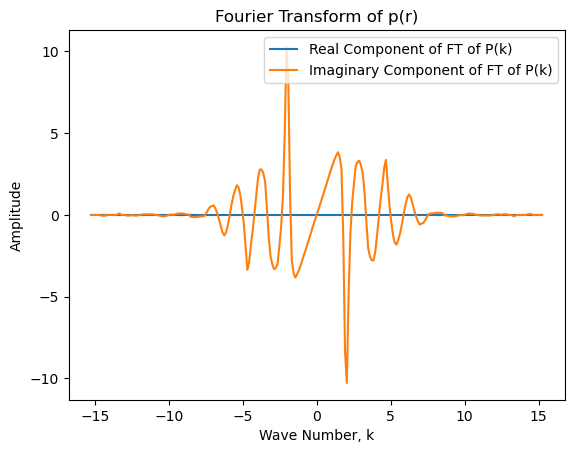

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from argon import YanData, dk

# Wave vector range (k values)
k_values = np.arange(-(len(YanData)-1)*dk, (len(YanData)-1)*dk + dk/2, dk)

# Structure Factor
# Create an even function from -len(YanData) to len(YanData)
flipped = np.flip(YanData[1:], 0)
S = np.concatenate((flipped, YanData))

print("Length of wave_numbers:", len(k_values))
print("Length of structure_factor:", len(S))

# Fourier Transform P(k)
def P(k_values):
    # Array of integrals to be returned
    result = [0] * len(k_values)
    
    for i in range(len(k_values)):
        result[i] = (np.pi/1j) * k_values[i] * (S[i]-1)
    
    return result

# Calculate P(k) for each wave number
FT = P(k_values)
print(len(FT))

plt.plot(k_values, np.real(FT), label="Real Component of FT of P(k)")
plt.plot(k_values, np.imag(FT), label="Imaginary Component of FT of P(k)")
plt.title("Fourier Transform of p(r)")
plt.xlabel("Wave Number, k")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

$p(r)$ is a imaginary and odd signal since<br>  

$$ p(r) = \int_{-\infty}^{\infty} \frac{1}{2i} (k) (S(k)-1) e^{ikr} \, dk $$

which is a product of and odd function, $k$, and an even function $S(k)$ (or more precisely $S(k) - 1$), which produce an odd function. Furthermore, we know that an imaginary and odd signal produces an imaginary and odd Fourier Transform, which is precisely what our plot shows.

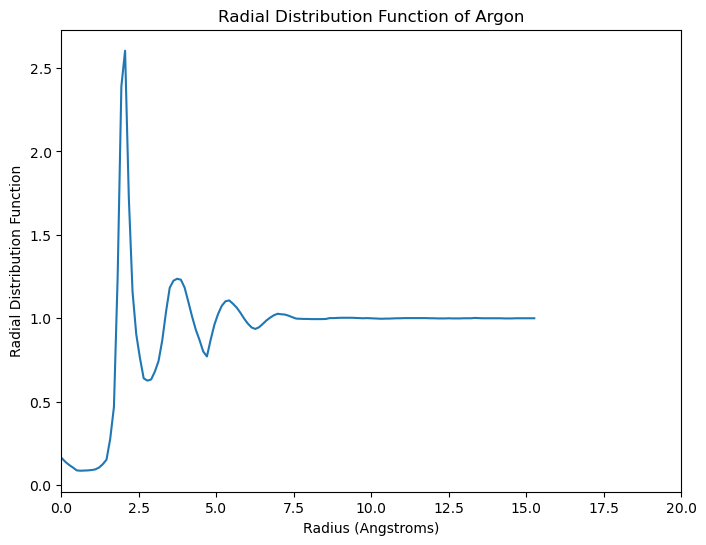

Average molecular radius of liquid argon: 7.589703225 Angstroms


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from argon import YanData

dk = 0.12                 # inverse Angstroms
massRho = 1.4273          # grams/cc 
molWeight = 39.948        # grams/mol
Navogadro = 6.0221367e23  # atoms/mol

def RDFcalc(S, dk, rho):
    # Compute the Fourier Transform of S(k)
    S_fft = np.fft.fft(S)
    
    # Calculate the wavenumber values
    N = len(S)
    k = np.fft.fftfreq(N, dk)
    
    # Computing g(r)
    g = np.fft.ifft(S_fft).real
    
    # Getting the r vectors
    r = np.arange(dk, N+dk) * dk
    
    return g, r

# Data from argon.py
S = YanData
rho = massRho

# Calculate RDF
gn, rn = RDFcalc(S, dk, rho)

# Plot the RDF
plt.figure(figsize=(8, 6))
plt.plot(rn, gn)
plt.xlabel('Radius (Angstroms)')
plt.ylabel('Radial Distribution Function')
plt.title('Radial Distribution Function of Argon')
plt.xlim(0, 20)
plt.show()

# Average distance
total = 0
for i in range(len(gn)):
    total += gn[i] * rn[i]
avg = total / len(rn)

print("Average molecular radius of liquid argon:", avg, "Angstroms")


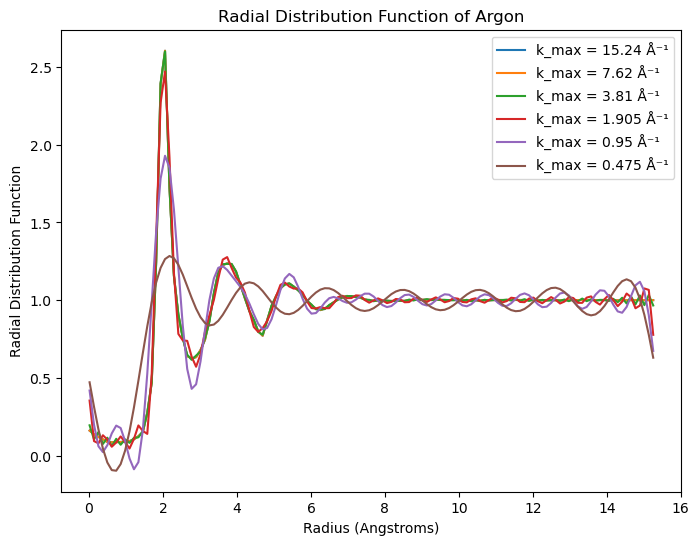

In [6]:
# Finding an adequate k_max

# Test values for k_max
k_max_values = [15.24, 7.62, 3.81, 1.905, 0.950, 0.475]  # Halving k_max each time

# Now RDFcalc takes in a k_max parameter
def RDFcalc_k_max(S, dk, rho, k_max): 
    
    # Compute the Fourier Transform of S(k)
    S_fft = np.fft.fft(S)
    
    # Calculate the wavenumber values
    N = len(S)
    k = np.fft.fftfreq(N, dk)
    
    # Boolean array to determine cutoff point for arrays
    restricted_k = np.abs(k) <= k_max
    restricted_S = S_fft * restricted_k
    
    # Computing g(r)
    g = np.fft.ifft(restricted_S).real 
    
    # Getting the r vectors
    r = np.arange(dk, N+dk) * dk
    
    return g, r

# Plot the RDF
plt.figure(figsize=(8, 6))

# Calculate and plot RDF for different k_max values
for k in k_max_values:
    gn, rn = RDFcalc_k_max(S, dk, massRho, k)
    plt.plot(rn, gn, label=f'k_max = {k} Å⁻¹')
    
plt.xlabel('Radius (Angstroms)')
plt.ylabel('Radial Distribution Function')
plt.title('Radial Distribution Function of Argon')
plt.legend()

It seems that the minimum value of $k_{max}$ is around 0.95 inverse angstroms. As shown in the plot above, sampling only values below this cutoff results in multiple additional peaks appearing at radii much further than expected (particularly evident in the plot labeled $k_{max} = 0.475A˚−1$). Theoretically, this phenomenon occurs because reducing $k_{max}$ too much leads to an undersampling of the Radial Distribution Function (RDF), causing aliasing effects. These aliasing effects manifest as additional peaks in the RDF, distorting the apparent structure of the material. Overall, there is a tradeoff between reducing $k_{max}$ and the accuracy of the g(r) plot; while reducing $k_{max}$ saves time and effort, excessive reduction beyond a certain threshold compromises the precision and fidelity of the g(r) plot.

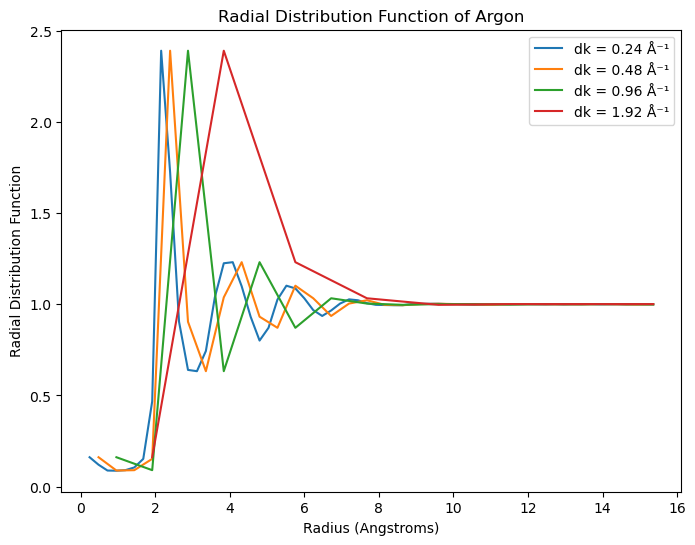

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from argon import YanData

og_dk = 0.12  # Original sampling interval (inverse Angstroms)

# Define the doubling factor for dk
doubling_factors = [2 ** i for i in range(1, 5)]

def RDFcalc_dk(S, rho, factor):
    # Calculate the new sampling interval dk
    dk = og_dk * factor
    
    # Calculate the number of points after subsampling
    N = len(S)
    N_subsampled = N // factor  # Ensure integer division
    
    # Subsample the data
    S_subsampled = S[::factor]
    
    # Calculate the wavenumber values based on the new dk
    k_subsampled = np.fft.fftfreq(N_subsampled, dk)
    
    # Compute the Fourier Transform of S(k)
    S_fft = np.fft.fft(S_subsampled)
    
    # Compute g(r)
    g = np.fft.ifft(S_fft).real
    
    # Generate the corresponding r values
    r = np.arange(dk, len(g) * dk + dk, dk)
    
    if (len(r) != len(g)):
        r = r[:-1]
    
    return g, r


plt.figure(figsize=(8, 6))
for factor in doubling_factors:
    
    # Calculate RDF for the current dk value
    gn, rn = RDFcalc_dk(YanData, massRho, factor)

    # Plot the RDF
    plt.plot(rn, gn, label=f'dk = {og_dk * factor} Å⁻¹')
plt.legend()
plt.xlabel('Radius (Angstroms)')
plt.ylabel('Radial Distribution Function')
plt.title('Radial Distribution Function of Argon')
plt.show()


Evidently, from the figure above, increasing dk decreases the resolution of the RDF. For values of dk up to about 0.96 Å⁻¹, the first two peaks are distinguishable (albeit they appear to peak at different r values), but for larger dk values, the appearance of the first two peaks is no longer guaranteed. Certainly, as seen on the plot, using dk = 1.92 Å⁻¹ does not allow one to discern the peaks properly at all. This is expected, as with a lower sampling frequency, less of the data will be used in the generation of the plot, meaning that not all the peaks/troughs will necessarily be captured. The theoretical justification lies in the Nyquist-Shannon sampling theorem, which states that in order to accurately reconstruct a signal (or function in this case), the sampling frequency must be at least twice the highest frequency present in the signal. If the sampling interval (dk) becomes too large, it will undersample the RDF, leading to aliasing effects and loss of important structural information.